In [6]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from datetime import datetime
import itertools

In [7]:
# ---------------------------------------------------------
# 0. SETUP CONFIGURATIONS
# ---------------------------------------------------------
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 5
DROPOUT = 0.15
NUM_CLASSES = 7

TRAIN_DIR = '/kaggle/input/skin-cancer-dataset/skin_cancer_dataset_final_complete/train'
VAL_DIR = '/kaggle/input/skin-cancer-dataset/skin_cancer_dataset_final_complete/validation'
TEST_DIR = '/kaggle/input/skin-cancer-dataset/skin_cancer_dataset_final_complete/test'

SAVE_PATH = "best_resnet152_checkpoint.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [8]:
# ---------------------------------------------------------
# 1. LOAD DATASETS
# ---------------------------------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=val_test_transforms)
test_ds = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['actinic_keratoses', 'basal_cell_carcinoma', 'benign_keratosis-like_lesions', 'melanocytic_Nevi', 'melanoma']


In [9]:
# ---------------------------------------------------------
# 2. EXTRACT LABELS FOR STATISTICS
# ---------------------------------------------------------
train_labels = np.array([y for _, y in train_ds])
val_labels = np.array([y for _, y in val_ds])
test_labels = np.array([y for _, y in test_ds])

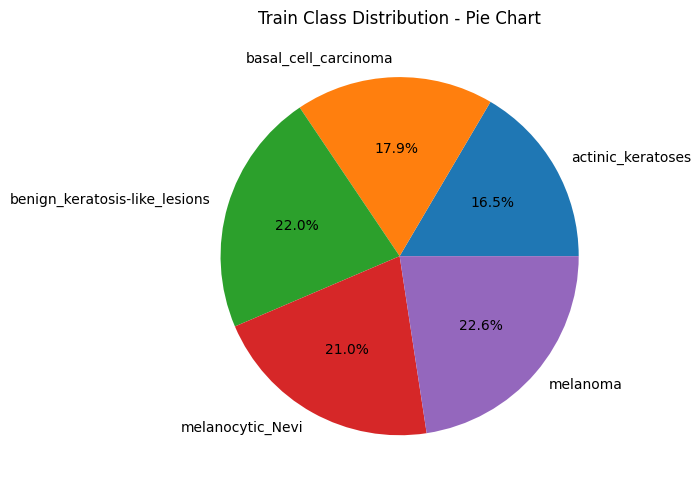

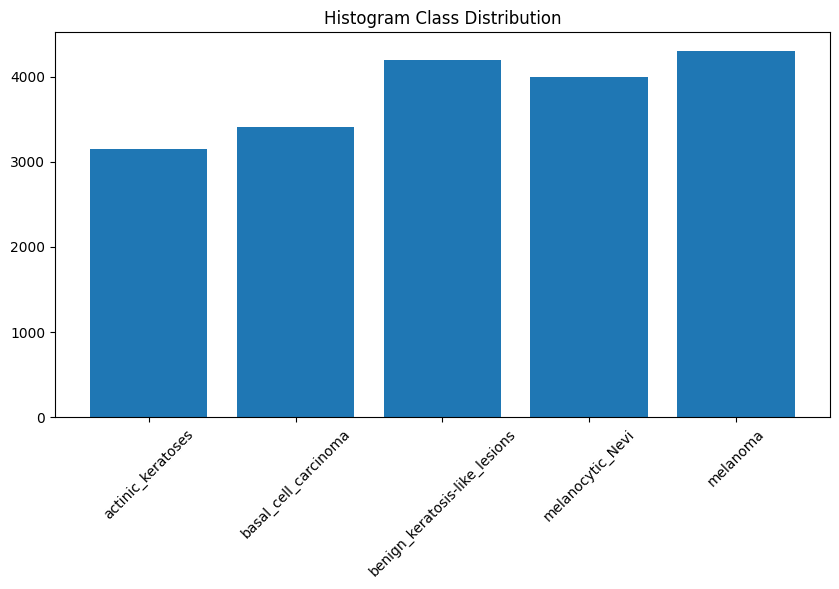

In [ ]:

plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.title("Train Class Distribution - Pie Chart")
plt.pie(np.bincount(train_labels), labels=class_names, autopct='%1.1f%%')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Histogram Class Distribution")
plt.bar(class_names, np.bincount(train_labels))
plt.xticks(rotation=45)
plt.show()

In [11]:
# ---------------------------------------------------------
# 4. MODEL: RESNET 152 + DROPOUT
# ---------------------------------------------------------
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)

# Modify FC with dropout
model.fc = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

best_val_loss = float("inf")
patience_counter = 0

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 216MB/s]  


In [ ]:

from tqdm import tqdm
import torch

EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
patience_counter = 0
SAVE_PATH = 'best_model.pth'

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("="*90)
print("STARTING TRAINING")
print("="*90 + "\n")

for epoch in range(EPOCHS):
    
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print("-" * 90)
    
    # TRAIN
    model.train()
    running_loss = 0
    correct, total = 0, 0
    
    # Progress bar for training
    train_pbar = tqdm(train_loader, desc="Training", ncols=100, colour='green')
    
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
        # Update progress bar with current metrics
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(correct/total):.4f}'
        })

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    # VALIDATION
    model.eval()
    val_running_loss = 0
    val_correct, val_total = 0, 0
    
    # Progress bar for validation
    val_pbar = tqdm(val_loader, desc="Validation", ncols=100, colour='blue')

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
            
            # Update progress bar with current metrics
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(val_correct/val_total):.4f}'
            })

    val_acc = val_correct / val_total
    val_loss = val_running_loss / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\n📊 Epoch Summary:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f} ({val_acc*100:.2f}%)")

    # Save BEST checkpoint (no overfitting)
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), SAVE_PATH)
        best_val_loss = val_loss
        patience_counter = 0
        print("   ✔ Saved Best Model Checkpoint")
    else:
        patience_counter += 1
        print(f"   ⏳ Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("\n" + "="*90)
            print("⛔ EARLY STOPPING TRIGGERED")
            print("="*90)
            break

print("\n" + "="*90)
print("✅ TRAINING COMPLETED")
print("="*90)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Model saved at: {SAVE_PATH}")


STARTING TRAINING


Epoch [1/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.45it/s, loss=0.5587, acc=0.7936]



📊 Epoch Summary:
   Train Loss: 0.2952 | Train Acc: 0.8901 (89.01%)
   Val Loss  : 0.6419 | Val Acc  : 0.7936 (79.36%)
   ✔ Saved Best Model Checkpoint

Epoch [2/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.43it/s, loss=0.5283, acc=0.8010]



📊 Epoch Summary:
   Train Loss: 0.1801 | Train Acc: 0.9349 (93.49%)
   Val Loss  : 0.7643 | Val Acc  : 0.8010 (80.10%)
   ⏳ Patience: 1/5

Epoch [3/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.44it/s, loss=0.3030, acc=0.8142]



📊 Epoch Summary:
   Train Loss: 0.1256 | Train Acc: 0.9539 (95.39%)
   Val Loss  : 0.5534 | Val Acc  : 0.8142 (81.42%)
   ✔ Saved Best Model Checkpoint

Epoch [4/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:32<00:00,  2.37it/s, loss=0.4276, acc=0.8055]



📊 Epoch Summary:
   Train Loss: 0.0990 | Train Acc: 0.9666 (96.66%)
   Val Loss  : 0.8034 | Val Acc  : 0.8055 (80.55%)
   ⏳ Patience: 1/5

Epoch [5/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.42it/s, loss=2.5071, acc=0.8179]



📊 Epoch Summary:
   Train Loss: 0.0930 | Train Acc: 0.9662 (96.62%)
   Val Loss  : 0.7044 | Val Acc  : 0.8179 (81.79%)
   ⏳ Patience: 2/5

Epoch [6/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.43it/s, loss=0.2286, acc=0.8344]



📊 Epoch Summary:
   Train Loss: 0.0671 | Train Acc: 0.9772 (97.72%)
   Val Loss  : 0.5895 | Val Acc  : 0.8344 (83.44%)
   ⏳ Patience: 3/5

Epoch [7/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.39it/s, loss=0.3671, acc=0.8216]



📊 Epoch Summary:
   Train Loss: 0.0723 | Train Acc: 0.9749 (97.49%)
   Val Loss  : 0.6927 | Val Acc  : 0.8216 (82.16%)
   ⏳ Patience: 4/5

Epoch [8/50]
------------------------------------------------------------------------------------------


Validation: 100%|██████████████████████████| 76/76 [00:31<00:00,  2.43it/s, loss=2.4656, acc=0.8434]


📊 Epoch Summary:
   Train Loss: 0.0563 | Train Acc: 0.9812 (98.12%)
   Val Loss  : 0.6946 | Val Acc  : 0.8434 (84.34%)
   ⏳ Patience: 5/5

⛔ EARLY STOPPING TRIGGERED

✅ TRAINING COMPLETED
Best Validation Loss: 0.5534
Model saved at: best_model.pth


In [15]:
# ---------------------------------------------------------
# 6. LOAD BEST MODEL CHECKPOINT
# ---------------------------------------------------------
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.numpy())

test_accuracy = accuracy_score(all_targets, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average="macro")

print("\n===== TEST METRICS =====")
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, target_names=class_names))


===== TEST METRICS =====
Test Accuracy: 0.8084596967278531
Precision: 0.7766092059735332
Recall: 0.6183897759680816
F1 Score: 0.6070553241812767

Classification Report:

                               precision    recall  f1-score   support

            actinic_keratoses       1.00      0.12      0.21        42
         basal_cell_carcinoma       0.78      0.79      0.79        67
benign_keratosis-like_lesions       0.70      0.39      0.50       142
             melanocytic_Nevi       0.93      0.90      0.91       858
                     melanoma       0.48      0.89      0.62       144

                     accuracy                           0.81      1253
                    macro avg       0.78      0.62      0.61      1253
                 weighted avg       0.84      0.81      0.80      1253



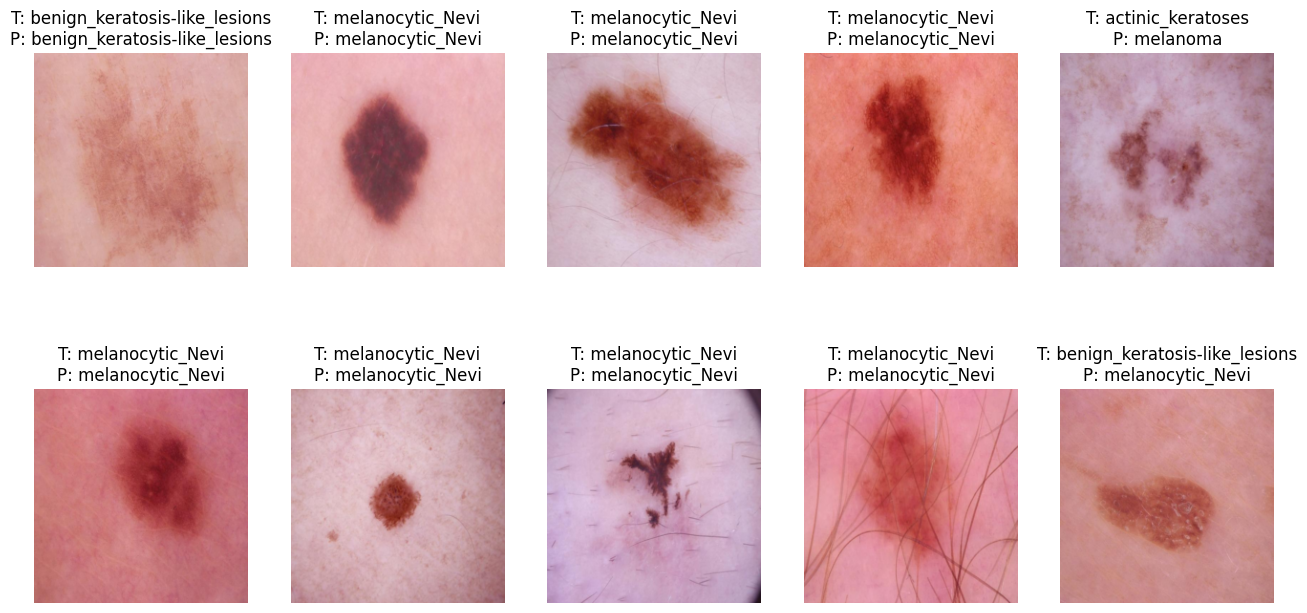

In [17]:
# ---------------------------------------------------------
# 8. RANDOM 10 TEST IMAGES WITH LABEL + PRED
# ---------------------------------------------------------
def show_random_predictions():
    idxs = random.sample(range(len(test_ds)), 10)

    plt.figure(figsize=(16, 8))
    for i, idx in enumerate(idxs):
        img, label = test_ds[idx]
        true_label = class_names[label]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_label = class_names[pred.argmax().item()]

        plt.subplot(2, 5, i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")
    plt.show()

show_random_predictions()

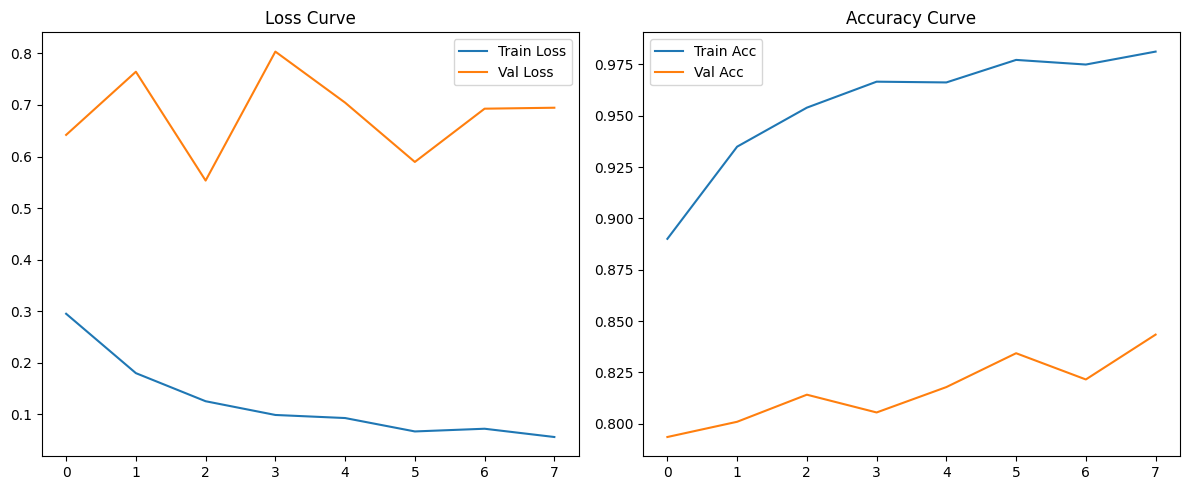

In [18]:
# ---------------------------------------------------------
# 9. VISUALIZE OVERALL TRAINING STATISTICS
# ---------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()